In [7]:
import src
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from src.crystal_models import BaselineShifter, SoftnormScaler

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from pyaldata import smooth_data

In [2]:
data_dir = Path('/Users/raeed/Library/CloudStorage/OneDrive-UniversityofPittsburgh/0-projects/cst-strat/cst-data/library/human cst-rtt/')
# filename = 'CST_CRS02b_06-03-2024.mat'
filename = 'CST_CRS07_06-07-2024.mat'
td = src.rnel_preproc.load_ts_data(
    filename=data_dir / filename,
    cols_to_expose=['Kin'],
    index_cols=[
        'trial',
        'task',
        'state',
        'session_time',
    ],
    signal_cols=[
        'pos',
        'vel',
        'targetpos',
        'targetvel',
        'Motor',
        'Sensory',
    ],
)

In [10]:
from lfads_tf2.utils import chop_data
from sklearn.model_selection import train_test_split
import h5py

# filename = '../data/CST_CRS02b_06-03-2024.hdf5'
filename = '../data/CST_CRS07_06-07-2024.hdf5'

window = 60
overlap = 40
tensor = chop_data(td['Motor'].values,window=window,overlap=overlap)
trial_id_map = chop_data(td.reset_index(level='trial')['trial'].values[:,None],window=window,overlap=overlap)
session_times = chop_data(td.reset_index(level='session_time')['session_time'].values[:,None],window=window,overlap=overlap)

nan_inds = np.isnan(tensor).any(axis=(1,2))
tensor = tensor[~nan_inds]
trial_id_map = trial_id_map[~nan_inds]
session_times = session_times[~nan_inds]

(
    train_inds,
    valid_inds,
    train_trial_id,
    valid_trial_id,
    train_times,
    valid_times,
    train_data,
    valid_data,
) = train_test_split(
    np.arange(tensor.shape[0]), trial_id_map, session_times, tensor, test_size=0.2
)

# with h5py.File(filename, "a") as hf:
#     hf.create_dataset("train_data", data=train_data, compression="gzip")
#     hf.create_dataset("valid_data", data=valid_data, compression="gzip")
#     hf.create_dataset("train_inds", data=train_inds, compression="gzip")
#     hf.create_dataset("valid_inds", data=valid_inds, compression="gzip")
#     hf.create_dataset("train_trial_id", data=train_trial_id, compression="gzip")
#     hf.create_dataset("valid_trial_id", data=valid_trial_id, compression="gzip")

In [12]:
from lfads_tf2.utils import load_posterior_averages, merge_chops

post_data = load_posterior_averages(
    '../results/lfads/20240607',
    merge_tv=True,
)
lfads_rates = pd.concat(
    [pd.DataFrame(spikes/20e-3,index=pd.TimedeltaIndex(times.squeeze()).round('20ms')) for spikes,times in zip(post_data.rates,session_times)],
    axis=0,
    keys=np.arange(len(post_data.rates)),
    names=['chop','session_times'],
)
lfads_rates

0          1          2         3    \
chop session_times                                                      
0    0 days 00:00:00         1.743022   6.684773   6.978733  1.510299   
     0 days 00:00:00.020000  4.041600  15.507290  17.836878  5.748861   
     0 days 00:00:00.040000  3.789877  12.954231  20.865305  6.055230   
     0 days 00:00:00.060000  3.109120  10.342016  20.319031  5.514940   
     0 days 00:00:00.080000  2.835895   9.500841  21.240723  5.515134   
...                               ...        ...        ...       ...   
3836 0 days 04:15:12.300000  3.104412  15.615047  14.340779  2.304226   
     0 days 04:15:12.320000  3.177456  15.697894  14.924181  2.417807   
     0 days 04:15:12.340000  3.325481  16.094851  15.372777  2.563127   
     0 days 04:15:12.360000  3.683032  17.039209  15.936356  2.779235   
     0 days 04:15:12.380000  1.540216   8.304177   7.120017  1.338937   

                                  4         5         6          7    \
chop session_times                                                     
0    0 days 00:00:00         0.053062  0.011222  0.638518  15.022897   
     0 days 00:00:00.020000  0.172897  0.059472  2.595302  43.155251   
     0 days 00:00:00.040000  0.121715  0.060596  2.187002  41.320461   
     0 days 00:00:00.060000  0.091188  0.051992  1.673415  34.982765   
     0 days 00:00:00.080000  0.075645  0.046955  1.505996  33.533096   
...                               ...       ...       ...        ...   
3836 0 days 04:15:12.300000  0.046007  0.007862  1.498908  26.278622   
     0 days 04:15:12.320000  0.045599  0.007601  1.540715  26.476366   
     0 days 04:15:12.340000  0.047769  0.007871  1.657278  27.326191   
     0 days 04:15:12.360000  0.056443  0.009845  1.917634  29.197306   
     0 days 04:15:12.380000  0.029119  0.004496  0.753443  15.360317   

                                  8         9    ...       182       183  \
chop session_times                               ...                       
0    0 days 00:00:00         0.611933  1.936597  ...  0.054758  0.428480   
     0 days 00:00:00.020000  0.906576  5.710696  ...  0.153882  1.227512   
     0 days 00:00:00.040000  0.700181  4.865145  ...  0.110857  1.017861   
     0 days 00:00:00.060000  0.548995  3.944407  ...  0.081458  0.835641   
     0 days 00:00:00.080000  0.489111  3.521201  ...  0.074458  0.820172   
...                               ...       ...  ...       ...       ...   
3836 0 days 04:15:12.300000  1.409299  1.909673  ...  0.110780  0.906323   
     0 days 04:15:12.320000  1.398052  1.938222  ...  0.109388  0.910212   
     0 days 04:15:12.340000  1.449653  2.024990  ...  0.110752  0.931575   
     0 days 04:15:12.360000  1.657659  2.201646  ...  0.123543  1.023595   
     0 days 04:15:12.380000  0.814520  1.286436  ...  0.038280  0.426702   

                                  184       185       186       187  \
chop session_times                                                    
0    0 days 00:00:00         0.110726  0.237037  0.239374  0.130693   
     0 days 00:00:00.020000  0.366542  1.232781  0.685924  0.373735   
     0 days 00:00:00.040000  0.342083  1.379743  0.521886  0.322625   
     0 days 00:00:00.060000  0.269797  1.196346  0.406663  0.283657   
     0 days 00:00:00.080000  0.256499  1.196547  0.386053  0.279383   
...                               ...       ...       ...       ...   
3836 0 days 04:15:12.300000  0.181397  0.304817  0.559799  0.414723   
     0 days 04:15:12.320000  0.174460  0.307976  0.557030  0.404560   
     0 days 04:15:12.340000  0.166668  0.316314  0.567635  0.400942   
     0 days 04:15:12.360000  0.166663  0.340336  0.613948  0.428123   
     0 days 04:15:12.380000  0.083427  0.166869  0.243581  0.181284   

                                   188       189        190       191  
chop session_times                                                     
0    0 days 00:00:00         10.264657  2.020384   4.636900  3.790654  
     0 days 00:00:

Need to roll my own chop-merging code here because overlap is more than half of the window size, which means that most of the data is modeled more than twice (in the case of 2/3 overlap, as is the case here, three times). In the future, this should be avoided, but for now, we'll make some bespoke code to handle this.

Note to future self: the code below just ignores the edge effects of just doing a simple averaging for each time point represented across chops. Ideally, we'd weight the timepoints at the end of a chop more heavily than the ones at the beginning, but that's a problem for another day.

In [19]:
motor_lfads = (
    lfads_rates
    .groupby('session_times')
    .agg('mean')
    .reindex(td.index.get_level_values('session_time'))
)
temp = pd.concat([motor_lfads],axis=1,keys=['motor lfads'],names=['signal','channel'])
td = td.join(temp)

/var/folders/wf/m89rq9p97kq6fdqj23hkrm_h0000gn/T/ipykernel_46175/2610110923.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  td
/Users/raeed/codebase/0-projects/cst-dynamics/env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/raeed/codebase/0-projects/cst-dynamics/env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/raeed/codebase/0-projects/cst-dynamics/env/lib

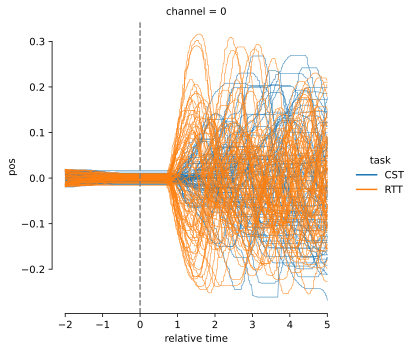

In [22]:

signal = 'pos'
temp = (
    td
    .pipe(src.munge.reindex_by_trial_time)
    .pipe(src.munge.get_epoch_data,epochs={'reach':slice('-2 sec','5 sec')})
    [[signal]]
    .stack(level='signal')
    .rename_axis(index={'signal': 'signal type'})
    [[0]]
    .stack()
    .to_frame(signal)
)
g = sns.relplot(
    data=temp,
    x='relative time',
    y=signal,
    hue='task',
    hue_order=['CST','RTT'],
    kind='line',
    row='channel',
    units='trial',
    estimator=None,
    errorbar=None,
    lw=0.5,
)
g.refline(x=0)
g.despine(trim=True)
g.tight_layout()


In [148]:
def remove_baseline(df):
    baseline = (
        df
        .dropna(axis=0)
        .pipe(src.munge.get_epoch_data,epochs={'presentation':slice('-0.5 sec','0 sec')})
        .groupby('trial')
        .agg('mean')
    )

    return df-baseline

temp = (
    td
    .dropna(axis=0)
    .pipe(src.munge.reindex_by_trial_time)
    .pipe(src.munge.hierarchical_assign,{
        'motor norm': lambda df: SoftnormScaler().fit_transform(df['motor lfads']),
    })
    .dropna(axis=0)
    .pipe(src.munge.hierarchical_assign,{
        'motor shift': lambda df: remove_baseline(df[['motor norm']])['motor norm'],
    })
)
temp

signal                                             pos                 vel  \
channel                                              0         1         0   
trial task state      trial_time                                             
1     CST  intertrial 0 days 00:00:00         0.007186 -0.003327  0.000000   
                      0 days 00:00:00.020000  0.007186 -0.003327  0.000000   
                      0 days 00:00:00.040000  0.007186 -0.003327  0.000000   
                      0 days 00:00:00.060000  0.007186 -0.003327  0.000000   
                      0 days 00:00:00.080000  0.007186 -0.003327  0.000000   
...                                                ...       ...       ...   
155   RTT  reach      0 days 00:00:07.960000  0.066816 -0.000269  0.071861   
                      0 days 00:00:07.980000  0.066816 -0.000269  0.036695   
                      0 days 00:00:08         0.066816 -0.000269 -0.027521   
                      0 days 00:00:08.020000  0.064522 -0.000269 -0.027521   
                      0 days 00:00:08.040000  0.064522 -0.000269 -0.038224   

signal                                                 targetpos       \
channel                                              1         0    1   
trial task state      trial_time                                        
1     CST  intertrial 0 days 00:00:00         0.000000  0.000000  0.0   
                      0 days 00:00:00.020000  0.000000  0.000000  0.0   
                      0 days 00:00:00.040000  0.000000  0.000000  0.0   
                      0 days 00:00:00.060000  0.000000  0.000000  0.0   
                      0 days 00:00:00.080000  0.000000  0.000000  0.0   
...                                                ...       ...  ...   
155   RTT  reach      0 days 00:00:07.960000 -0.024463 -0.024213  0.0   
                      0 days 00:00:07.980000 -0.019877 -0.024213  0.0   
                      0 days 00:00:08        -0.007645 -0.024213  0.0   
                      0 days 00:00:08.020000 -0.007645 -0.024213  0.0   
                      0 days 00:00:08.040000 -0.004587 -0.024213  0.0   

signal                                       targetvel      Motor       ...  \
channel                                              0    1     0    1  ...   
trial task state      trial_time                                        ...   
1     CST  intertrial 0 days 00:00:00         0.041184  0.0   0.0  0.0  ...   
                      0 days 00:00:00.020000  0.041184  0.0   0.0  0.0  ...   
                      0 days 00:00:00.040000  0.041184  0.0   0.0  1.0  ...   
                      0 days 00:00:00.060000  0.041184  0.0   0.0  0.0  ...   
                      0 days 00:00:00.080000  0.041184  0.0   0.0  0.0  ...   
...                                                ...  ...   ...  ...  ...   
155   RTT  reach      0 days 00:00:07.960000 -0.203655  0.0   0.0  0.0  ...   
                      0 days 00:00:07.980000 -0.203655  0.0   0.0  0.0  ...   
                      0 days 00:00:08        -0.203655  0.0   0.0  1.0  ...   
                      0 days 00:00:08.020000 -0.203655  0.0   1.0  0.0  ...   
                      0 days 00:00:08.040000  0.000000  0.0   0.0  0.0  ...   

signal                                       motor shift                      \
channel                                              182       183       184   
trial task state      trial_time                                               
1     CST  intertrial 0 days 00:00:00          -0.004986 -0.049783 -0.022164   
                      0 days 00:00:00.020000    0.010983  0.040991  0.005084   
                      0 days 00:00:00.040000    0.004052  0.017173  0.002479   
                      0 days 00:00:00.060000   -0.000684 -0.003528 -0.005221   
                      0 days 00:00:00.080000   -0.001812 -0.005285 -0.006637   
...                                                  ...       ...       ...   
155   RTT  reach      0 days 00:00:07.960000   -0.002284 

/var/folders/wf/m89rq9p97kq6fdqj23hkrm_h0000gn/T/ipykernel_46175/1766795116.py:24: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  td
/Users/raeed/codebase/0-projects/cst-dynamics/env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/raeed/codebase/0-projects/cst-dynamics/env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/raeed/codebase/0-projects/cst-dynamics/env/li

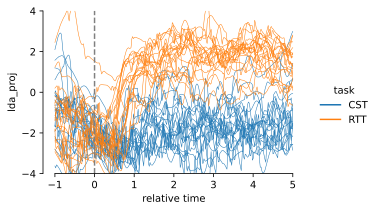

In [166]:
temp = (
    td
    .dropna(axis=0)
    .pipe(src.munge.reindex_by_trial_time)
    .pipe(src.munge.hierarchical_assign,{
        'motor norm': lambda df: SoftnormScaler().fit_transform(df['motor lfads']),
    })
    # .dropna(axis=0)
    # .pipe(src.munge.hierarchical_assign,{
    #     'motor shift': lambda df: remove_baseline(df[['motor norm']])['motor norm'],
    # })
    .dropna(axis=0)
    .pipe(src.munge.get_epoch_data,epochs={'presentation':slice('3 sec','6 sec')})
    .reset_index(level='task')
)

lda_pipe = Pipeline([
    ('pca', PCA(n_components=15)),
    ('lda', LinearDiscriminantAnalysis()),
])
lda_pipe.fit(temp['motor norm'],temp['task'])

temp = (
    td
    .dropna(axis=0)
    .pipe(src.munge.reindex_by_trial_time)
    .pipe(src.munge.hierarchical_assign,{
        'motor norm': lambda df: SoftnormScaler().fit_transform(df['motor lfads']),
    })
    # .dropna(axis=0)
    # .pipe(src.munge.hierarchical_assign,{
    #     'motor shift': lambda df: remove_baseline(df[['motor norm']])['motor norm'],
    # })
    .dropna(axis=0)
    .pipe(src.munge.get_epoch_data,epochs={'reach':slice('-1 sec','5 sec')})
    .assign(
        lda_proj=lambda df: lda_pipe.transform(df['motor norm'])
    )
    ['lda_proj']
    .to_frame(signal)
    .droplevel('state')
    .unstack(level='relative time')
    .groupby('task')
    .sample(n=20)
    .stack(level='relative time')
)
g = sns.relplot(
    data=temp,
    x='relative time',
    y='lda_proj',
    hue='task',
    hue_order=['CST','RTT'],
    kind='line',
    height=3,
    aspect=1.5,
    errorbar=None,
    estimator=None,
    units='trial',
    lw=0.5,
)
g.refline(x=0)
g.despine(trim=True)
g.tight_layout()
g.set(ylim=(-4, 4))


<AxesSubplot: xlabel='Train data', ylabel='Test data'>

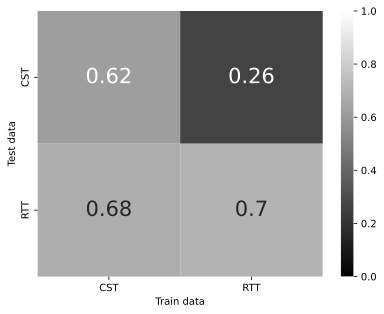

In [182]:

cst_model = LinearRegression()
rtt_model = LinearRegression()

def get_test_labels(df,test_size=0.2):
    gss = GroupShuffleSplit(n_splits=1,test_size=test_size)
    _,test = next(gss.split(
        df[('vel',0)],
        groups=df.index.get_level_values('trial'),
    ))
    return np.isin(np.arange(df.shape[0]),test)

temp = (
    td
    .pipe(src.munge.hierarchical_assign,{
        'motor norm': lambda df: SoftnormScaler().fit_transform(df['motor lfads']),
    })
    .dropna(axis=0)
    .pipe(src.munge.reindex_by_trial_time)
    .pipe(src.munge.hierarchical_assign,{
        'motor pca': lambda df: pd.DataFrame(PCA(n_components=40).fit_transform(df['motor norm']),index=df.index),
    })
    .pipe(src.munge.get_epoch_data,epochs={'reach':slice('-2 sec','6 sec')})
    .assign(**{'Test set': lambda df: get_test_labels(df)})
)

models=src.decoder_analysis.fit_models(temp,signal='motor pca',target_name=('vel',0),sample_size=20000)
scores=src.decoder_analysis.score_models(temp,signal='motor pca',models=models,target_name=('vel',0))
heatmap_fig,ax = plt.subplots(1,1)
sns.heatmap(
    ax=ax,
    data=scores.unstack()[['CST','RTT']],
    vmin=0,
    vmax=1,
    annot=True,
    annot_kws={'fontsize': 21},
    cmap='gray',
)

In [183]:
def score_trials(df,signal='motor pca',models=None,target_name=('vel',0)):
    trial_scores = (
        df
        .groupby(['task','trial'])
        .apply(lambda trial: pd.Series({
            f'{model_name} score': model.score(trial[signal].values,trial[target_name])
            for model_name,model in models.items()
        }))
    )
    return trial_scores

trial_scores=score_trials(temp,signal='motor pca',models=models,target_name=('vel',0))

import plotly.express as px
fig = px.scatter(
    trial_scores.reset_index(),
    x='CST score',
    y='RTT score',
    color='task',
    hover_data=['trial'],
    marginal_x='violin',
    marginal_y='violin',
    template='plotly_white',
    width=600,
    height=600,
    color_discrete_sequence=px.colors.qualitative.T10,
)
fig.show()

/Users/raeed/codebase/0-projects/cst-dynamics/env/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



/Users/raeed/codebase/0-projects/cst-dynamics/env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/raeed/codebase/0-projects/cst-dynamics/env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/raeed/codebase/0-projects/cst-dynamics/env/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/Users/raeed/codebase/0-projects/cst-dynamics/env/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 t

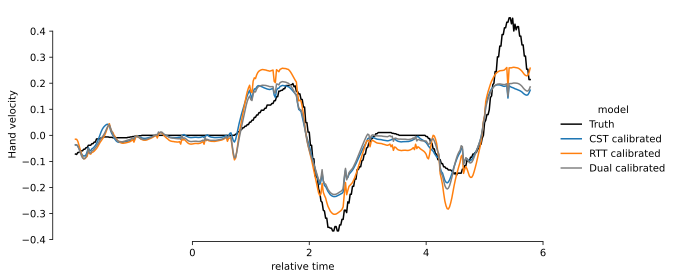

In [213]:
trials_to_plot = [136]
trial_pred = (
    temp
    .xs(trials_to_plot[0],level='trial')
    .pipe(src.munge.hierarchical_assign,{
        f'{model_name} calibrated': lambda df,model=model: pd.DataFrame(model.predict(df['motor pca'].values),index=df.index)
        for model_name,model in models.items()
    })
    [['vel','CST calibrated','RTT calibrated','Dual calibrated']]
    .xs(0,level='channel',axis=1)
    .rename(axis='columns',mapper={'vel': 'Truth'})
    .rename_axis(columns={'signal': 'model'})
    .stack()
    .rename('Hand velocity')
    .reset_index()
    [['relative time','model','Hand velocity']]
)
g=sns.relplot(
    data=trial_pred,
    x='relative time',
    y='Hand velocity',
    hue='model',
    hue_order=['Truth','CST calibrated','RTT calibrated','Dual calibrated'],
    palette=['k','C0','C1','0.5'],
    kind='line',
    height=4,
    aspect=2,
)
# g.axes[0,0].set_yticks([-200,0,200])
g.axes[0,0].set_xticks([0,2,4,6])
sns.despine(fig=g.fig,trim=True)

In [55]:
# subspace_split_pipeline = Pipeline([
#     ('joint_pca',src.models.JointSubspace(n_comps_per_cond=20,signal='motor lfads',condition='task',remove_latent_offsets=False)),
# ])
from src.crystal_models import JointSubspace, DekODec

temp = (
    td
    .pipe(src.munge.hierarchical_assign,{
        'motor norm': lambda df: SoftnormScaler().fit_transform(df['motor lfads']),
    })
    .dropna(axis=0)
    .pipe(src.munge.reindex_by_trial_time)
    .pipe(src.munge.get_epoch_data,epochs={'reach':slice('-2 sec','6 sec')})
    .assign(**{'Test set': lambda df: get_test_labels(df)})
)

joint_model = JointSubspace(n_comps_per_cond=20,condition='task',remove_latent_offsets=False)
another_temp = joint_model.fit_transform(temp['motor norm'])

dekodec_model = DekODec(var_cutoff=0.99,condition='task')
another_one = dekodec_model.fit_transform(another_temp)

Optimizing...
                                            f: +6.773229e+04   |grad|: 2.131229e+05
acc TR+   k:     1     num_inner:     0     f: +1.396523e+04   |grad|: 9.232265e+04   exceeded trust region
acc TR+   k:     2     num_inner:     2     f: +2.912374e+03   |grad|: 2.268464e+04   exceeded trust region
acc       k:     3     num_inner:     1     f: +1.279245e+03   |grad|: 7.166596e+03   exceeded trust region
acc       k:     4     num_inner:     6     f: +5.408624e+02   |grad|: 4.561562e+03   exceeded trust region
acc       k:     5     num_inner:     6     f: +2.935730e+02   |grad|: 1.662077e+03   reached target residual-kappa (linear)
acc TR+   k:     6     num_inner:     9     f: +1.330948e+02   |grad|: 3.098306e+03   exceeded trust region
acc       k:     7     num_inner:     3     f: +1.030515e+02   |grad|: 1.614256e+02   reached target residual-kappa (linear)
REJ TR-   k:     8     num_inner:    30     f: +1.030515e+02   |grad|: 1.614256e+02   exceeded trust region
acc 

/var/folders/wf/m89rq9p97kq6fdqj23hkrm_h0000gn/T/ipykernel_46175/3883858330.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  dekodec_split


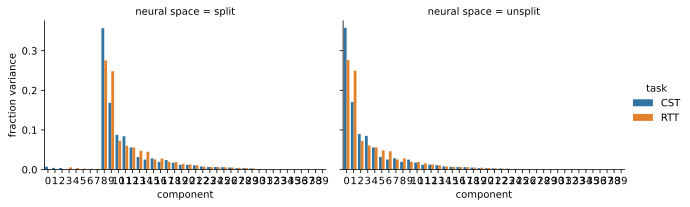

In [99]:
dekodec_split = pd.concat([another_temp,another_one],axis=1,keys=['unsplit','split'],names=['neural space','component'])

col_var = (
    dekodec_split
    .groupby('task')
    .agg('var')
    .stack(level='neural space')
)
total_var = col_var.sum(axis='columns')
compared_var = (
    (col_var.stack()/total_var)
    .rename('fraction variance')
    .reset_index()
)
sns.catplot(
    data=compared_var,
    x='component',
    y='fraction variance',
    hue='task',
    kind='bar',
    col='neural space',
    sharex=True,
    sharey=True,
    aspect=1.5,
    height=3,
)